In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook

WORKERS = 2
CHANNEL = 3

import warnings
warnings.filterwarnings("ignore")
IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

# Introduction. Explore first, train later.

Hi everyone! As Aravind Eye Hospital is one of my favorite organization in the world; they take care of poor people's eyes for free with an impressive sustainable business model. I will try my best to contribute something to our community. One intuitive way to improve the performance of our model is to simply improve the quality of input images. In this kernel, I will share two ideas which I hope may be useful to some of you :

- **Reducing lighting-condition effects** : as we will see, images come with many different lighting conditions, some images are very dark and difficult to visualize. We can try to convert the image to gray scale, and visualize better. Alternatively, there is a better approach. We can try the method of Ben Graham (last competition's winner)
- **Cropping uninformative area**: everyone know this :) Here, I just find the codes from internet and choose the best one for you :)

We are going to apply both techniques to both the official data, and the past competition data (shout out @tanlikesmath for creating this dataset! https://www.kaggle.com/tanlikesmath/diabetic-retinopathy-resized . In the updated version, I also try @donkeys' dataset https://www.kaggle.com/donkeys/retinopathy-train-2015 , which is .png which may be have higer image quality than .jpeg format)


In [2]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)

(3112,) (3112,) (550,) (550,)


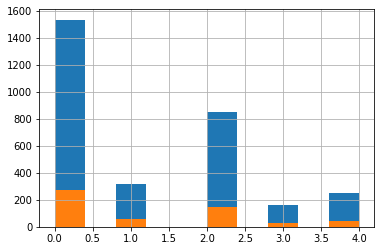

In [3]:
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()  # 蓝色 训练集数量
valid_y.hist()  # 橙色 验证集数量

## Simple picture to explain Diabetic Retinopathy
How do we know that a patient have diabetic retinopahy? There are at least 5 things to spot on. Image credit https://www.eyeops.com/
![image.png](https://sa1s3optim.patientpop.com/assets/images/provider/photos/1947516.jpeg)


From quick investigations of the data (see various pictures below), I found that Hemorrphages, Hard Exudates and Cotton Wool spots are quite easily observed. However, I still could not find examples of Aneurysm or Abnormal Growth of Blood Vessels from our data yet. Perhaps the latter two cases are important if we want to catch up human benchmnark using our model.



# Further improve by auto-cropping

To crop out the uninformative black areas which are evident on pic(0,1), pic(0,3) and pic(4,1), we can try auto cropping. I found 4 alternative codes from https://stackoverflow.com/questions/13538748/crop-black-edges-with-opencv and https://codereview.stackexchange.com/questions/132914/crop-black-border-of-image-using-numpy/132934 ... Fortunately one method works perfectly for a gray scale image, but none works on a color image. In this kernel, I modify the method working on gray-scale a bit to make it suitable for a color image.


In [4]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


Try Cropping the images

I have tested on around 200 images, and the method works great. However, if anybody find the outlier cases which cause the auto crop to fail, please let me know. I think now the eye pictures are very like the moon by the way :)

**IMPORTANT UPDATE** on Kernel V.9 I found that there is indeed a case in private test set making the old version of crop function fail. (I spent my 13 submissions until I found this bug) E.g. if there is an adversarial image (super dark) in the private test set, the crop function will crop everything and result in 0 dimension image. I have fixed this bug in this kernel version, but I still could not guarantee whether there are other cases in a private test that will make the crop function fail or not. Update on V11 Now I was able to have a valid LB score with the new crop function, so if anybody still have some submission errors, that is the reason of other bugs.



# A Important Update on Color Version of Cropping & Ben's Preprocessing

At first, when I wrote this kernel, I could not make a color crop nicely, so I thought that gray scale is a better representation. Now I believe that color version is better, so from this point on I will use color cropping

Below is the cropped of the color version. For color version, note that I use argument sigmaX = 30 of cv2.GaussianBlur, where Ben actually used sigmaX = 10 which may have better performance. I just feel that this sigmaX = 30 or sigmaX = 50 make beautiful [sometimes bloody] yellow moon pictures. Just for the purpose of illustration.

Please refer to https://www.tutorialkart.com/opencv/python/opencv-python-gaussian-image-smoothing/ .


In [5]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

# Create Dataset

In [6]:
df_old = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')

In [7]:
save_dir = "../input/diabetic-retinopathy-resized/ben_preprocessing_sigmaX10"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for idx, row in tqdm_notebook(df_old.iterrows()):
    path=f"../input/diabetic-retinopathy-resized/resized_train/{row['image']}.jpeg"
    image = load_ben_color(path,sigmaX=10)
    Image.fromarray(image).save(os.path.join(save_dir, "{}.png".format(row['image'])))

In [8]:
save_dir = "../input/aptos2019-blindness-detection/train_images_ben_preprocessing_sigmaX10"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for idx, row in tqdm_notebook(df_train.iterrows()):
    path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
    image = load_ben_color(path,sigmaX=10)
    Image.fromarray(image).save(os.path.join(save_dir, "{}.png".format(row['id_code'])))

In [9]:
save_dir = "../input/aptos2019-blindness-detection/test_images_ben_preprocessing_sigmaX10"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for idx, row in tqdm_notebook(df_test.iterrows()):
    path=f"../input/aptos2019-blindness-detection/test_images/{row['id_code']}.png"
    image = load_ben_color(path,sigmaX=10)
    Image.fromarray(image).save(os.path.join(save_dir, "{}.png".format(row['id_code'])))